<a href="https://colab.research.google.com/github/sarojkhanal-git/CBEAS_Whole_brain_and_Hippocampal_Segmentation/blob/main/SwinUNETR_NEW_PIPELINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
%pip install "monai==1.4.1rc1" -q
#%pip install torchinfo -q
#%pip install thop -q
#%pip install torchio -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.1 MB/s eta 0:00:00


In [4]:
import os
import torch
import glob
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd

#import torchio as tio
from monai.networks.nets import SwinUNETR
from monai.data import DataLoader, Dataset, decollate_batch
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd,
    RandSpatialCropd, RandFlipd, RandRotate90d, ToTensord, Lambda, AsDiscrete, Activations, Lambdad
)
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from sklearn.model_selection import train_test_split

set_determinism(42)

In [5]:
images = sorted(glob.glob("OASIS_500/Images/*.nii.gz"))[:500]
labels = sorted(glob.glob("OASIS_500/Labels/*.nii.gz"))[:500]

for f, g in zip(images, labels):
  if f.split('/')[2][:8] != g.split('/')[2][:8]:
    raise ValueError("Images and labels do not match")

print(f"No. of Images: {len(images)}\nNo. of Labels: {len(labels)}")

No. of Images: 500
No. of Labels: 500


In [7]:
lut_path = "FreeSurferColorLUT.txt"

def visualize_image(mri_image, label_image, slice_num, array = False):

  if array == False:
    mri_image = nib.load(mri_image).get_fdata()
    label_image =nib.load(label_image).get_fdata()

  df = pd.read_csv(lut_path,sep='\s+', comment = '#', names = ['Label_ID', 'Label_Name', 'R', 'G', 'B', 'A'], usecols = ['Label_ID', 'Label_Name', 'R', 'G', 'B'])

  unique_labels = np.unique(label_image)

  rgb_img = np.zeros((*label_image.shape, 3), dtype = np.uint8)

  for labels in unique_labels:
     rgb_values = df.loc[df['Label_ID'] == labels, ['R', 'G', 'B']].values[0]
     rgb_img[label_image == labels] = rgb_values

  fig, axs = plt.subplots(1, 3, figsize = (15, 15))
  axs[0].imshow(mri_image[slice_num,: ,:], cmap = 'gray')
  axs[0].set_title('MRI Slice')
  axs[0].axis('off')

  axs[1].imshow(rgb_img[slice_num, :, :, :])
  axs[1].set_title('Label Slice')
  axs[1].axis('off')

  axs[2].imshow(mri_image[slice_num, :, :], cmap = 'gray')
  axs[2].imshow(rgb_img[slice_num, :, :, :], alpha = 0.5)
  axs[2].set_title('Overlay')
  axs[2].axis('off')

  plt.show()

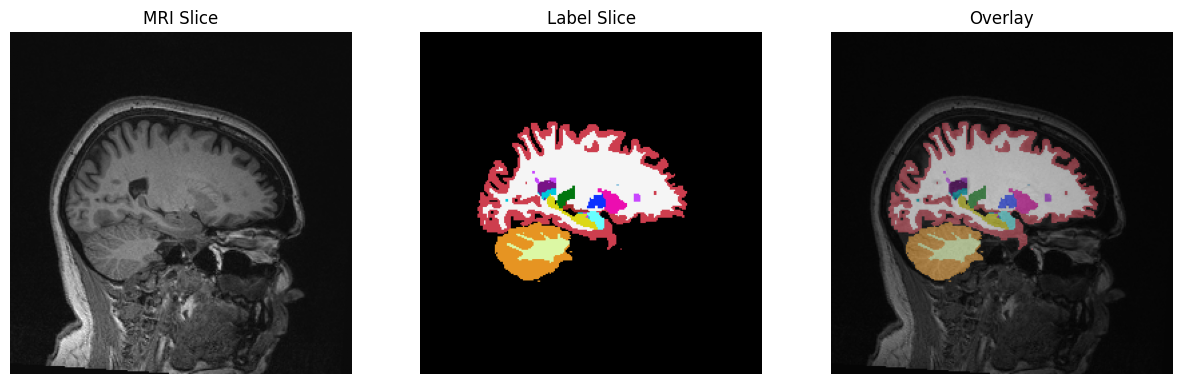

In [8]:
visualize_image(images[245],labels[245], 110)

####Function to make labels contiguous

In [6]:
def replace_freesurfer_index_with_contiguous(seg):
   label_index=np.unique(seg)
   for items in label_index:
     seg[seg==items]=np.where(label_index==items)[0][0]
   return seg

In [7]:
BATCH_SIZE = 1
NUM_CLASSES = 45
ROI_SIZE = (160, 160, 160)
NUM_WORKERS = 2

In [8]:
data_dicts = [
    {"image": img, "label": lbl}
    for img, lbl in zip(images, labels)
]

In [9]:
train_data, test_val_data = train_test_split(data_dicts, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_val_data, test_size=0.5, random_state=42)

##Transforms

In [10]:
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    Lambdad(keys=["label"], func=replace_freesurfer_index_with_contiguous),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),
    RandSpatialCropd(keys=["image", "label"], roi_size=ROI_SIZE, random_size=False),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandRotate90d(keys=["image", "label"], prob=0.5, max_k=3),
    ToTensord(keys=["image", "label"]),
])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    Lambdad(keys=["label"], func=replace_freesurfer_index_with_contiguous),
    Lambda(replace_freesurfer_index_with_contiguous),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),
    ToTensord(keys=["image", "label"]),
])

In [11]:
train_ds = Dataset(data=train_data, transform=train_transforms)
val_ds = Dataset(data=val_data, transform=val_transforms)
test_ds = Dataset(data=test_data, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=NUM_WORKERS)

##MODEL

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=ROI_SIZE,
    in_channels=1,
    out_channels=NUM_CLASSES,
    feature_size=24,
    use_checkpoint=True,
).to(device)

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


In [13]:
loss_fn = DiceCELoss(
    softmax=True,
    to_onehot_y=True,
    lambda_dice=0.6,
    lambda_ce=0.4,
)

In [21]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)

In [15]:
dice_metric = DiceMetric(include_background=False, reduction="mean")
hd_metric = HausdorffDistanceMetric(include_background=False, percentile=95)

##Functions to load and save model and checkpoints

In [16]:
def save_best_model(model, best_model_path):
    torch.save(model.state_dict(), best_model_path)

In [17]:
def save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path):
    checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'dice_mean': dice_mean,
    'epoch_list' : epoch_list,
    'val_dice_list' : val_dice_list,
    'train_loss_list' : train_loss_list,
    'best_metric': best_metric,
    'best_metric_epoch': best_metric_epoch,
    }
    torch.save(checkpoint, checkpoint_path)


In [18]:
def load_checkpoint(path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    dice_mean = checkpoint['dice_mean']
    epoch_list = checkpoint['epoch_list']
    val_dice_list = checkpoint['val_dice_list']
    train_loss_list = checkpoint['train_loss_list']
    best_metric = checkpoint['best_metric']
    best_metric_epoch = checkpoint['best_metric_epoch']
    return epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch

##Load Checkpoint

In [19]:
#epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch = load_checkpoint('Path')

##Epochs and Validation

In [22]:
max_epochs = 100
val_interval = 2

###Run if Checkpoints are not loaded

In [23]:
train_loss_list = []
val_dice_list   = []
val_hd95_list = []
epoch_list      = []
dice_mean = -1
best_metric = -1
best_metric_epoch = -1

##Train and Validation Loop

In [24]:
from tqdm import tqdm
import datetime

In [ ]:
checkpoint_path = 'feb23_24feature_Checkpoint.pth'
best_model_path = 'feb23_24feature_best_dice_model.pth'

#Training Loop
for epoch in range(max_epochs):
    print(f"Epoch [{epoch+1}/{max_epochs}] {datetime.datetime.now()}")
    model.train()
    epoch_loss = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
        inputs = batch["image"].to(device)
        labels = batch["label"].to(device).long()

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    #scheduler.step()
    train_loss_list.append(epoch_loss)
    print(f"  Train loss: {epoch_loss:.4f}")
    save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path)


    # Validation Loop
    if (epoch + 1) % val_interval == 0:
        model.eval()
        dice_vals = []
        with torch.no_grad():
            val_inputs = None
            val_labels = None
            val_outputs = None
            for val_data in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", leave=False):
                inputs = batch["image"].to(device)
                labels = batch["label"].to(device)

                outputs = sliding_window_inference(
                    inputs,
                    roi_size=ROI_SIZE,
                    sw_batch_size=4,
                    predictor=model,
                    overlap=0.25,
                    mode="gaussian"
                )
                outputs = torch.argmax(outputs, dim=1, keepdim=True)
                dice_metric(y_pred=outputs, y=labels)
                hd_metric(y_pred=outputs, y=labels)


        dice_mean = dice_metric.aggregate().item()
        hd_val = hd_metric.aggregate().item()
        dice_metric.reset()
        hd_metric.reset()
        val_dice_list.append(dice_mean)
        val_hd95_list.append(hd_val)
        epoch_list.append(epoch + 1)
        print(f"  Val Dice: {dice_mean:.4f}, Val HD95: {hd_val:.2f}")

        # Save the best model
        if dice_mean > best_metric:
            best_metric = dice_mean
            best_metric_epoch = epoch + 1
            save_best_model(model, best_model_path)
            print("   Saved new best model")


print(f"\nTraining complete. Best val Dice: {best_metric:.4f} at epoch {best_metric_epoch}")


Epoch [1/100] 2025-02-23 16:15:00.589403


  Train loss: 0.8874
Epoch [2/100] 2025-02-23 16:29:06.312331


  Train loss: 0.6971


  Val Dice: 0.5018, Val HD95: 55.96
   Saved new best model
Epoch [3/100] 2025-02-23 16:44:35.759989


  Train loss: 0.6387
Epoch [4/100] 2025-02-23 16:58:27.511536


  Train loss: 0.5862


  Val Dice: 0.3718, Val HD95: 51.66
Epoch [5/100] 2025-02-23 17:13:35.195222


  Train loss: 0.5345
Epoch [6/100] 2025-02-23 17:27:22.362492


  Train loss: 0.5034


  Val Dice: 0.3410, Val HD95: 52.92
Epoch [7/100] 2025-02-23 17:42:28.263638


  Train loss: 0.4779
Epoch [8/100] 2025-02-23 17:56:16.049761


  Train loss: 0.4575


  Val Dice: 0.5378, Val HD95: 48.48
   Saved new best model
Epoch [9/100] 2025-02-23 18:11:21.825047


  Train loss: 0.4376
Epoch [10/100] 2025-02-23 18:25:10.356913


  Train loss: 0.4028


  Val Dice: 0.8126, Val HD95: 12.08
   Saved new best model
Epoch [11/100] 2025-02-23 18:40:15.817154


  Train loss: 0.3809
Epoch [12/100] 2025-02-23 18:54:03.600272


  Train loss: 0.3489


  Val Dice: 0.6849, Val HD95: 26.48
Epoch [13/100] 2025-02-23 19:09:08.514638


  Train loss: 0.3233
Epoch [14/100] 2025-02-23 19:22:58.366633


  Train loss: 0.3120


  Val Dice: 0.6966, Val HD95: 49.28
Epoch [15/100] 2025-02-23 19:38:04.363036


  Train loss: 0.3003
Epoch [16/100] 2025-02-23 19:51:52.729513


Training Epoch 16:  80%|████████  | 321/400 [11:08<02:43,  2.07s/it]

##Plotting of Loss Curves

In [ ]:
len(train_loss_list), len(val_dice_list), len(epoch_list)

(0, 0, 0)

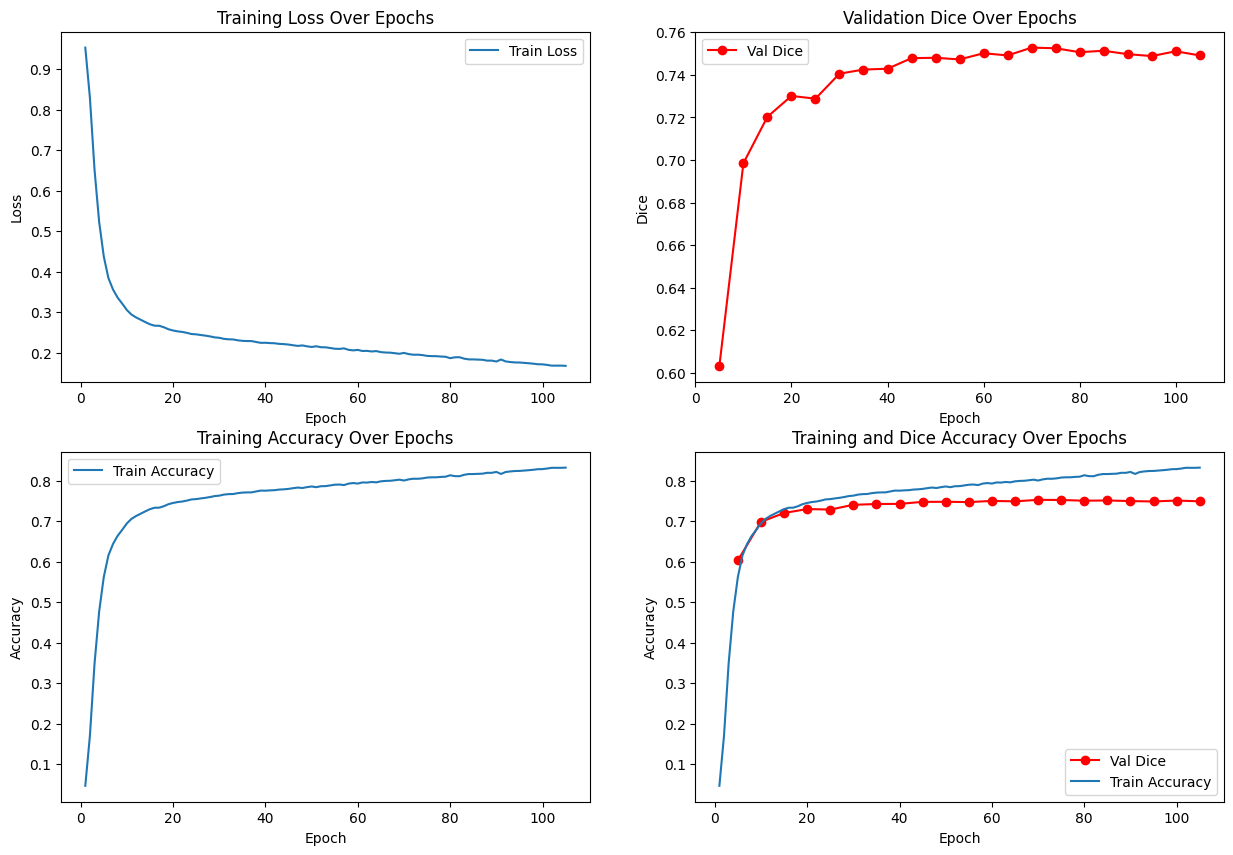

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0 ,0].plot(range(1, max_epochs+1), train_loss_list, label="Train Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_title("Training Loss Over Epochs")
axs[0, 0].legend()

axs[0, 1].plot(epoch_list, val_dice_list, 'r-o', label="Val Dice")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Dice")
axs[0, 1].set_title("Validation Dice Over Epochs")
axs[0, 1].legend()

axs[1, 0].plot(range(1, max_epochs+1), 1 - np.array(train_loss_list[:]), label="Train Accuracy")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].set_title("Training Accuracy Over Epochs")
axs[1, 0].legend()

axs[1, 1].plot(epoch_list, val_dice_list, 'r-o', label="Val Dice")
axs[1, 1].plot(range(1, max_epochs+1), 1 - np.array(train_loss_list[:]), label="Train Accuracy")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].set_title("Training and Dice Accuracy Over Epochs")
axs[1, 1].legend()

plt.show()

In [ ]:
# Final Test
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_metrics = {"dice": [], "hd95": []}

with torch.no_grad():
    for batch in test_loader:
        inputs = batch["image"].to(device)
        labels = batch["label"].to(device)

        # Use sliding window for full 256x256x256 inference
        outputs = sliding_window_inference(
            inputs, ROI_SIZE, 4, model, overlap=0.25, mode="gaussian"
        )
        outputs = torch.argmax(outputs, dim=1, keepdim=True)

        dice_metric(y_pred=outputs, y=labels)
        hd_metric(y_pred=outputs, y=labels)

test_dice = dice_metric.aggregate().item()
test_hd = hd_metric.aggregate().item()
print(f"\nFinal Test - Dice: {test_dice:.4f}, HD95: {test_hd:.2f}")